In [1]:
import torch
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F


# Overview

Our goal is to create a classifier to detect metastatic cancer in images.

We will first examine what our data looks like. Below we can see a single row in our dataset. The images we're using are of size 96x96. The color space is in RGB.

In [3]:
class ImageData(Dataset):
    def __init__(self, image_dir, label_df, transform=None):
        self.image_dir = image_dir
        self.label_df = label_df
        self.transform = transform

    def __len__(self):
        return len(self.label_df)

    def __getitem__(self, idx):
        img_name = self.label_df.iloc[idx, 0]
        label = self.label_df.iloc[idx, 1]
        img_path = self.image_dir+img_name+".tif"

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label)

        return image, label

In [4]:
from torch.utils.data import DataLoader

image_dir = 'data/train/'
transform = transforms.Compose([])
label_df_filtered = pd.read_csv('filtered_label_table.csv')
dataset = ImageData(image_dir=image_dir, label_df=label_df_filtered, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

### Image Sizes

We will first examine what our data looks like. Below we can see a single row in our dataset. The images we're using are of size 96x96. The color space is in RGB.

Label: 1
Image size: 96x96


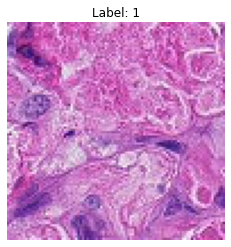

In [5]:
import matplotlib.pyplot as plt


image, label = dataset[1]

print(f"Label: {label}")
print("Image size: {}x{}".format(image.width,image.height))


plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# EDA


### Class distributions
We will examine the class distributions in our data. Our results show that there is a marginal imbalance in the features with a 60/40 split. Where 60% of our labels are negative and 40% are positive.

The difference is however not enough for intervention.  

0    0.600395
1    0.399605
Name: label, dtype: float64


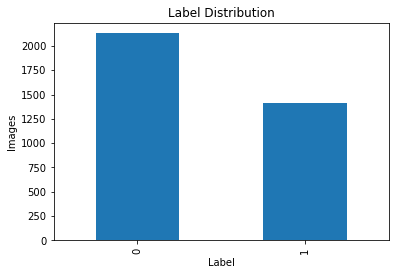

In [6]:
label_counts = label_df_filtered['label'].value_counts()
print(label_counts / len(label_df_filtered))

# Plot class distribution
import matplotlib.pyplot as plt
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Images')
plt.show()

### Image Size Distribution

We will confirm that all our images are the same size. This is an important step to make sure there are as few problems down the line as possible

In [7]:
sizes = []


first_image,_ = dataset[0]

first_width = first_image.width
first_height = first_image.height

for image, label in dataset:

  assert(image.width == first_width)
  assert(image.height == first_height)


print("All images are the same size")



All images are the same size


# Building our CNN


We will create a simple CNN with 1 Conv2d layer and 1 MaxPool2d layer. We will be using ReLU for the activations. We're feeding all 3 color channels into the model since the color plays an important role in metastatic cancer cell detection. 



Below is the shape of each of our layers: 

| Layer         | Output Shape  |
|:--------------|:--------------|
| Input         | (3, 96, 96)    |
| Conv2d        | (32, 96, 96)   |
| MaxPool2d     | (32, 48, 48)   |
| Flatten       | (73728,)       |
| FC1 (Linear)  | (128,)         |
| FC2 (Linear)  | (2,)           |

In [8]:

class CNN1(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN1, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32 * 48 * 48, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [9]:
model = CNN1(num_classes=2) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Training 

We will train our model for 3 epochs. We're using our ImageDataset object from earier wrapped within a dataloader with batch_size = 32.

In [10]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)

image_dir = 'data/train/'
transform = transforms.Compose([transforms.ToTensor()])
label_df_filtered = pd.read_csv('filtered_label_table.csv')
dataset = ImageData(image_dir=image_dir, label_df=label_df_filtered, transform=transform)

train_size = int(0.7 * len(dataset)) 
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


def train(epochs,model,criterion,optimizer):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)    
            loss = criterion(outputs, labels)     
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)        
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()         
            total += labels.size(0)
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {epoch_loss:.4f}")



train(model=model,optimizer=optimizer,criterion=criterion,epochs=3)

Using device: cpu
Epoch [1/3]  Loss: 0.6667
Epoch [2/3]  Loss: 0.6556
Epoch [3/3]  Loss: 0.6442


## Hyper Parameter Tuning

We will get a baseline perfomance before we begin tuning the hyperparameters

In [11]:
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


def run_tests(model,test_loader):
    model.eval() 
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad(): 
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

run_tests(model=model,test_loader=test_loader)

Test Accuracy: 0.5959


### Adding another CNN layer 

We will try improving on our test accuracy. Firstly, we will add another Conv2d layer to our model. The increased complexity could help an underfitting model. 

In [12]:

class CNN2(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 24 * 24, 128) 
        self.fc2 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

As shown below, increasing model complexity did not yield much improvement in our score. 

In [13]:
model = CNN2(num_classes=2) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train(model=model,criterion=criterion,optimizer=optimizer,epochs=3)

run_tests(model=model,test_loader=test_loader)

Epoch [1/3]  Loss: 0.6720
Epoch [2/3]  Loss: 0.6696
Epoch [3/3]  Loss: 0.6691
Test Accuracy: 0.5987


### Increasing the learning rate

We will now try increasing the learning rate from 0.001 to 0.01. It could be the case that 3 epochs is simply not enough for SGD to find a suitable minimum with a low learning rate. 

As shown in the results below, the test accuracy is still largely unchanged despite and order of magnitude increase in learning rate.  

In [14]:
model = CNN1(num_classes=2) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train(model=model,criterion=criterion,optimizer=optimizer,epochs=3)

run_tests(model=model,test_loader=test_loader)

Epoch [1/3]  Loss: 2.8524
Epoch [2/3]  Loss: 0.6728
Epoch [3/3]  Loss: 0.6729
Test Accuracy: 0.5987


### A different loss function  

We will try using Adam instead of SGD. Adam has an adaptive learning rate with momentum so it is better suited for navigating a more complex loss enviroment. 

From our testing, it does appear that Adam is preferred over SGD for this problem. Our test accuracy is much higher compared to SGD. 

In [15]:
model = CNN1(num_classes=2) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train(model=model,criterion=criterion,optimizer=optimizer,epochs=3)

run_tests(model=model,test_loader=test_loader)

Epoch [1/3]  Loss: 1.0313
Epoch [2/3]  Loss: 0.5455
Epoch [3/3]  Loss: 0.5059
Test Accuracy: 0.7632


### More Training 

We will take our best running hyperparameters and increase the number of training cycles and learning rate to reduce our loss. 

As shown below, our loss quickly reduces. However, despite our learning loss being much lower than with the previous test, our test accuracy is actually higher. This suggests that at 10 epochs our model has overfit. 

In [21]:
model = CNN1(num_classes=2) 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train(model=model,criterion=criterion,optimizer=optimizer,epochs=10)

run_tests(model=model,test_loader=test_loader)

Epoch [1/10]  Loss: 1.8608
Epoch [2/10]  Loss: 0.5512
Epoch [3/10]  Loss: 0.5060
Epoch [4/10]  Loss: 0.4594
Epoch [5/10]  Loss: 0.4141
Epoch [6/10]  Loss: 0.3935
Epoch [7/10]  Loss: 0.3305
Epoch [8/10]  Loss: 0.2751
Epoch [9/10]  Loss: 0.2345
Epoch [10/10]  Loss: 0.2059
Test Accuracy: 0.7321


# Conclusion 

Our best perfoming model has a test accuracy of 0.7632, this suggests that the model is better than a random guess, although not accurate enough to be useful, especially for domains such as medicine where a higher standard of accuracy is expected. 

Our hyperparameter training found that the 1 layer vs 2 layers makes little difference, and Adam is a much better loss function for this problem compared to SGD. We also discovered that 10 epochs is too many training cycles as our test accuracy at 10 epochs was much higher than our training loss would suggest. 

DModel Architecture (25 pts)

escribe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 


Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?